Name: 曾俊雄 M112040035 曾宇謙 M122040014

# Environment

In [1]:
from bs4 import BeautifulSoup
from copy import deepcopy
# import ffn
# import matplotlib as mpl
import cvxopt
import cvxpy as cp
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pandas as pd
import random
import requests
import scipy
import scipy.interpolate as sci
import scipy.optimize as sco
import scipy.stats.mstats as scs
import sklearn as sk
import yfinance as yf
# from functools import reduce

## Parameters
# Length of total period
start_date = '2010-01-01'
end_date   = '2023-11-30'

# Risk free rate
rf = 0.01

# Size of testing set.
test_size = 0.4

# The initial ratio between the length of rolling window and the length of holding period.
# Adopt the ratio presented with the daily data in Peralta & Zareei (2016).
# kappa = 1000 / 20
# kappa = 192 / 12
kappa = 3

# The interval multiplier of the rolling window.
# Day
interval_rw = 25

# The interval multiplier of the holding period.
interval_hp = 20

# Set the random seed.
random_state = 2023

# Set the threshold to kill missing values.
miss_thresh = 0

# Set the closed-form formula for computaiton of optimal weights of the tangency portfolio.
method = 3

# Data Access

In [2]:
## Download the information regarding the FTSE TWSE Taiwan 50 Index from Wiki.
wikiURL = 'https://zh.wikipedia.org/zh-tw/%E8%87%BA%E7%81%A350%E6%8C%87%E6%95%B8'


session = requests.Session()
page = session.get(wikiURL)
c = page.content

soup = BeautifulSoup(c, 'html.parser')

mydivs = soup.findAll('table',{'class':'wikitable'})

## Extract the list of the stock components included in the table from the information crawled.
WikiTable = pd.read_html(str(mydivs))
# Convert list to dataframe
df = pd.DataFrame(WikiTable[0])

# Data Cleaning

In [3]:
df_new = df[['股票代號.1', '名稱.1']]
df_new.columns = ['股票代號', '名稱']
df = df.drop(columns=['股票代號.1', '名稱.1'])
df = df.append(df_new, ignore_index=True)
df['股票代號'] = df['股票代號'].str.replace('臺證所：', '')
df['股票代號'] = df['股票代號']+'.TW'

## Inconsistent stock data.
df = df[ df['股票代號'] != '4938.TW' ]

stockList = " ".join(df["股票代號"].values)

## Add the component stocks that existed in the index previously.
#
histStock = ''

stockListFull = stockList + histStock

Stock = yf.download(stockListFull, start=start_date, end=end_date)

## Extract the adjusted closed prices.
Stock_close = deepcopy( Stock['Adj Close'] )

## Extract the adjusted closed prices.
Stock_open = deepcopy( Stock['Open'] )

## Remove the stocks whose price data is insufficient.
Stock_close = Stock_close.dropna(axis='columns', thresh=int( len(Stock_close)*(1-miss_thresh) ))
Stock_open  = Stock_open.dropna(axis='columns', thresh=int( len(Stock_open)*(1-miss_thresh) ))
Stock       = Stock.dropna(axis='columns', thresh=int( len(Stock_open)*(1-miss_thresh) ))

# Stock_close.isnull().sum().sum()
## Fill the remaining missing values by interpolation.
Stock_close = Stock_close.interpolate()
Stock_open  = Stock_open.interpolate()

## Retrieve the Index.
TW50 = yf.download('0050.tw', start=start_date, end=end_date)
TW50_close = deepcopy(TW50)['Adj Close']
TW50_open = deepcopy(TW50)['Open']

<ipython-input-3-d6225240c2cc>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_new, ignore_index=True)


[*********************100%%**********************]  49 of 49 completed
[*********************100%%**********************]  1 of 1 completed


# Data Preprocessing

In [4]:
## Build initial settings.
Returns = Stock_close.pct_change()[1:]
# Returns = Returns.loc[:, (Returns == 0).sum() <= 200]
N = len(Returns.columns)
ones = np.ones(N)
zeros = np.zeros(N)
# Returns.isnull().sum().sum()
# For balanced panel.
Stock_close = Stock_close[1:]
Stock_open  = Stock_open[1:]
Stock       = Stock[1:]

Stock_close.index = pd.to_datetime(Stock_close.index)
Stock_open.index = pd.to_datetime(Stock_open.index)

Dates = Stock.index


## Split data for cross-validation.
# Test set.
sizeOfTest  = int(len(Stock_close) * test_size)
Test_close  = Stock_close.iloc[ -sizeOfTest: ]
Test_open   = Stock_open.iloc[ -sizeOfTest: ]
Test_return = Returns.loc[ Test_close.index[0]: ]

# Training set.
Train_close  = Stock_close.iloc[ :-sizeOfTest ]
Train_open   = Stock_open.iloc[ :-sizeOfTest ]
Train_return = Returns.loc[ :Train_close.index[-1] ]

# Tangency Portfolio Construction

In [57]:
def Func_OptPortf(r):
    cvxopt.solvers.options['show_progress'] = False

    assetNum = r.shape[1]         # Num of assets in each portfolio.
    riskLvs = 30                 # Divide how many different levels of risk willing to take (risk aversion).
    riskAversionLv = [10 ** (2 * i / riskLvs - 2) for i in range(riskLvs)]

    days = r.shape[0]

    # Calculate the parameters of convex optimization.
    q = cvxopt.matrix((((1 + r).cumprod() ** (1 / days))[-1:] ** 252 - 1 - rf).values.T)
    P = cvxopt.matrix(r.cov().values * 252)

    G = cvxopt.matrix(-np.eye(assetNum))
    h = cvxopt.matrix(0.0, (assetNum, 1))
    A = cvxopt.matrix(1.0, (1, assetNum))
    b = cvxopt.matrix(1.0)

    ## Calculate the optimized weights of the allocation of assets in the portfolio where maximize {E(r) - 1/2 λ Var(r)} under different levels of risk taken (i.e., diff λ).
    # To solve the maximization problem, the objective function takes negative so that it can be solved under convex optimization.
    weights = [cvxopt.solvers.qp(2 * P, -level * q, G, h, A, b)['x'] for level in riskAversionLv]

    ## Calculate the return rates and risk levels of the optimized allocation of assets under different risk aversion levels.
    returns = np.array([np.dot(q.T, x) * 100 for x in weights])
    vols = np.array([np.sqrt(np.dot(x.T, P * x)) * 100 for x in weights])

    # Find the weights and index w.r.t. the greatest Sharpe ratio.
    idx = (returns / vols).argmax()
    optwt = weights[idx]
    optwt = pd.Series(optwt, index=r.columns)

    return idx, optwt, returns, vols


## Different closed-form of computation of optimal weight of tangency portfolio.
def Func_OptWeight(dta, method=3):
    if method == 1:
        # Method 1.
        cov_inv = np.linalg.inv(dta.cov())
        mean_ret = np.exp(np.log(1+dta).mean())-1

        weight = cov_inv @ (mean_ret - rf) / (ones.T @ cov_inv @ (mean_ret - rf))
        weight = pd.Series(weight, index=dta.columns)

    if method == 2:
        # Method 2.
        _, weight, _, _ = Func_OptPortf(dta)

    if method == 3:
        # Method 3.
        OptIdx, _, EF_Returns, _ = Func_OptPortf(dta)
        mu = EF_Returns[OptIdx][0][0]

        return_mean = np.array( np.exp(np.log(1+dta).mean())-1 )
        zeros = np.zeros(2)
        new_col1 = np.concatenate([return_mean, zeros]).reshape(-1, 1)
        new_col2 = np.concatenate([ones, zeros]).reshape(-1, 1)

        A = np.vstack((2 * dta.cov(), return_mean, ones))
        A = np.hstack((A, new_col1, new_col2))

        b = np.zeros(N+2)
        b[-2], b[-1] = mu, 1

        weight = np.linalg.inv(A).dot(b)
        weight = weight[:-2]

    return weight

# Parameter Construction

The aim of this subsection is setting the parameters that are, at least partially, decided by other parameters rather than absoultely manually.

In [56]:
## Set for the minimum length of time for a training observation.
# Holding period + rolling window.
kappa = int(kappa)

## Set the number of times for slicing windows + bootstrapping.
numOfBoots = int( len(Train_close)//(1+kappa) * 2 )

## To preserve sufficient large sample space,
# the maximum length of training period (i.e., rolling window + holding period) is limited.
SampleSize = int( len( Stock_close ) * 0.1 )
# T - (M+H) + 1 > SampleSize.
maxTrainL = int( len(Train_close) - SampleSize + 1)

maxRolling = int( maxTrainL//(1+kappa) * kappa )
maxHolding = int( maxRolling / kappa )

## Debug setting.
# numOfBoots = 30      # For debug.
# method = 3

# Search of hyperparameter - Greedy for Length of Rolling Window

In [58]:
def Func_Search(initial_date, method=method):
    ## Compute the optimal weights under tangency portfolio using the return data of rolling window.
    rolling = Returns.iloc[initial_date : initial_date + width_rolling]

    weight = Func_OptWeight(rolling, method=method)

    # Remove the weights that are too small.
    weight[ np.abs(weight) < 0.001 ] = 0
    # Keep the sum of the weight as 100%.
    weight = weight / weight.sum()

    ## Compute the number of shares bought at the beginning of the holding period.
    shares = 1 * weight / Train_open.iloc[initial_date + width_rolling]
    ## Compute the share holding at the end of the holding period.
    holding = shares * Train_close.iloc[initial_date + width_train - 1]

    ## Compute the Sharpe ratio for the holding period.
    var = Returns.iloc[initial_date + width_rolling : initial_date + width_train].cov()
    var = weight.T @ var @ weight

    r_single = holding.sum() - 1

    return r_single, var
## To shorten the searching time, use a list of candidates instead of interval searching.
M_list = [ 75 * (multiplier+1) for multiplier in range( int(maxRolling / 75) ) ]
M_list = [25, 50] + M_list

In [ ]:
TrainingSets = []
Sharpes_1 = []
PositiveCounts = []
VarCounts = []
Ms = []

## Search the best length of rolling window (M) by loop.
for _i in M_list:
    width_rolling = _i
    width_holding = int( width_rolling / kappa )
    width_train = width_holding + width_rolling
    _periods = []
    _sharpes = []
    _positiveSharpe = 0

    ## 1. Search M through the method of slicing window first.
    _startIdx = 0
    _endIdx = width_train
    _positiveSharpe = 0
    for _j in range( len(Train_close)//width_train ):
        ## Save the period for later bootstrapping.
        _periods.append( Returns.iloc[_startIdx : _startIdx + width_train] )

        ## Compute the position at the end of the holding period
        # and the corresponding variance of the portfolio constructed.
        # The start index gives the period of rolling window and holding period.
        tmp_holding, tmp_var = Func_Search(_startIdx)

        # if tmp_var < 0.01:
        tmp_sharpe = (tmp_holding.sum() - 1 - rf) / tmp_var
        _sharpes.append(tmp_sharpe)

        ## Record the occurrence of the positive Sharpe ratios.
        if tmp_holding.sum() - 1 - rf > 0:
            _positiveSharpe += 1

        # print(tmp_sharpe)

        _startIdx += width_train

    ## Utilize the remaining training data.
    if len(Train_close)//width_train != 0:
        _startIdx = len(Train_close) - width_train

        ## Save the period for later bootstrapping.
        _periods.append( Returns.iloc[_startIdx : _startIdx + width_train] )

        ## Compute the position at the end of the holding period
        # and the corresponding variance of the portfolio constructed.
        # The start index gives the period of rolling window and holding period.
        tmp_holding, tmp_var = Func_Search(_startIdx)

        # if tmp_var < 0.01:
        tmp_sharpe = (tmp_holding.sum() - 1 - rf) / tmp_var
        _sharpes.append(tmp_sharpe)

        ## Record the occurrence of the positive Sharpe ratios.
        if tmp_holding.sum() - 1 - rf > 0:
            _positiveSharpe += 1

        # print(tmp_sharpe)


    ## 2. Bootstrap the training periods for remaining number of loops.
    boots = numOfBoots - len(_sharpes)

    random.seed(random_state + _i)
    idx = [ random.randint(0, len(Train_close) - width_train) for _ in range(boots) ]

    for _startIdx in idx:
        ## Save the period for later bootstrapping.
        _periods.append( Returns.iloc[_startIdx : _startIdx + width_train] )

        ## Compute the position at the end of the holding period
        # and the corresponding variance of the portfolio constructed.
        # The start index gives the period of rolling window and holding period.
        tmp_holding, tmp_var = Func_Search(_startIdx)

        # if tmp_var < 0.01:
        tmp_sharpe = (tmp_holding.sum() - 1 - rf) / tmp_var
        _sharpes.append(tmp_sharpe)

        ## Record the occurrence of the positive Sharpe ratios.
        if tmp_holding.sum() - 1 - rf > 0:
            _positiveSharpe += 1

        # print(tmp_sharpe)

    ## Winsorize the Sharpes to prevent the dominance of the outliers.
    _sharpes = scs.winsorize( np.array(_sharpes), limits=[0.05, 0.05] )

    TrainingSets.append(_periods)
    Sharpes_1.append( np.exp(np.mean(_sharpes) * 252/width_holding) - 1 )
    Ms.append(width_rolling)
    PositiveCounts.append(_positiveSharpe)

    # print(_i, '/', maxRolling+1)

M_temp = Ms[ np.argmax(Sharpes_1) ]

KeyboardInterrupt: ignored

In [ ]:
print(M_temp)

675


# Search of hyperparameter - Length of Holding Period

In [ ]:
## Update the maximum length of the holding period to be tested.
maxHolding = maxTrainL - M_temp
# interval_hp = 1

TrainingSets = []
Sharpes_2 = []
PositiveCounts = []
Hs = []

## Search the best length of holding period (H) by loop.
for _i in range( interval_hp, maxHolding+1, interval_hp ):
    width_holding = _i
    width_rolling = M_temp
    width_train = width_holding + width_rolling
    _periods = []
    _sharpes = []
    _positiveSharpe = 0

    ## 1. Search H through the method of slicing window first.
    _startIdx = 0
    _endIdx = width_train
    _positiveSharpe = 0
    for _j in range( len(Train_close)//width_train ):
        ## Save the period for later bootstrapping.
        _periods.append( Returns.iloc[_startIdx : _startIdx + width_train] )

        ## Compute the position at the end of the holding period
        # and the corresponding variance of the portfolio constructed.
        # The start index gives the period of rolling window and holding period.
        tmp_holding, tmp_var = Func_Search(_startIdx)

        # if tmp_var < 0.01:
        tmp_sharpe = (tmp_holding.sum() - 1 - rf) / tmp_var
        _sharpes.append(tmp_sharpe)

        ## Record the occurrence of the positive Sharpe ratios.
        if tmp_holding.sum() - 1 - rf > 0:
            _positiveSharpe += 1

        # print(tmp_sharpe)

        _startIdx += width_train

    ## Utilize the remaining training data.
    if len(Train_close)//width_train != 0:
        _startIdx = len(Train_close) - width_train

        ## Save the period for later bootstrapping.
        _periods.append( Returns.iloc[_startIdx : _startIdx + width_train] )

        ## Compute the position at the end of the holding period
        # and the corresponding variance of the portfolio constructed.
        # The start index gives the period of rolling window and holding period.
        tmp_holding, tmp_var = Func_Search(_startIdx)

        # if tmp_var < 0.01:
        tmp_sharpe = (tmp_holding.sum() - 1 - rf) / tmp_var
        _sharpes.append(tmp_sharpe)

        ## Record the occurrence of the positive Sharpe ratios.
        if tmp_holding.sum() - 1 - rf > 0:
            _positiveSharpe += 1

        # print(tmp_sharpe)


    ## 2. Bootstrap the training periods for remaining number of loops.
    boots = numOfBoots - len(_sharpes)

    random.seed(random_state + _i)
    idx = [ random.randint(0, len(Train_close) - width_train) for _ in range(boots) ]

    for _startIdx in idx:
        ## Save the period for later bootstrapping.
        _periods.append( Returns.iloc[_startIdx : _startIdx + width_train] )

        ## Compute the position at the end of the holding period
        # and the corresponding variance of the portfolio constructed.
        # The start index gives the period of rolling window and holding period.
        tmp_holding, tmp_var = Func_Search(_startIdx)

        # if tmp_var < 0.01:
        tmp_sharpe = (tmp_holding.sum() - 1 - rf) / tmp_var
        _sharpes.append(tmp_sharpe)

        ## Record the occurrence of the positive Sharpe ratios.
        if tmp_holding.sum() - 1 - rf > 0:
            _positiveSharpe += 1

        # print(tmp_sharpe)

    ## Winsorize the Sharpes to prevent the dominance of the outliers.
    _sharpes = scs.winsorize( np.array(_sharpes), limits=[0.05, 0.05] )

    TrainingSets.append(_periods)
    Sharpes_2.append( np.exp(np.mean(_sharpes) * 252/width_holding) - 1 )
    Hs.append(width_holding)
    PositiveCounts.append(_positiveSharpe)

    # print(_i, '/', maxHolding+1)


H_target = Hs[ np.argmax(Sharpes_2) ]

5 / 731
10 / 731
15 / 731
20 / 731
25 / 731
30 / 731
35 / 731
40 / 731
45 / 731
50 / 731
55 / 731
60 / 731
65 / 731
70 / 731
75 / 731
80 / 731
85 / 731
90 / 731
95 / 731
100 / 731
105 / 731
110 / 731
115 / 731
120 / 731
125 / 731
130 / 731
135 / 731
140 / 731
145 / 731
150 / 731
155 / 731
160 / 731
165 / 731
170 / 731
175 / 731
180 / 731
185 / 731
190 / 731
195 / 731
200 / 731
205 / 731
210 / 731
215 / 731
220 / 731
225 / 731
230 / 731
235 / 731
240 / 731
245 / 731
250 / 731
255 / 731
260 / 731
265 / 731
270 / 731
275 / 731
280 / 731
285 / 731
290 / 731
295 / 731
300 / 731
305 / 731
310 / 731
315 / 731
320 / 731
325 / 731
330 / 731
335 / 731
340 / 731
345 / 731
350 / 731
355 / 731
360 / 731
365 / 731
370 / 731
375 / 731
380 / 731
385 / 731
390 / 731
395 / 731
400 / 731
405 / 731
410 / 731
415 / 731
420 / 731
425 / 731
430 / 731
435 / 731
440 / 731
445 / 731
450 / 731
455 / 731
460 / 731
465 / 731
470 / 731
475 / 731
480 / 731
485 / 731
490 / 731
495 / 731
500 / 731
505 / 731
510 / 731


In [ ]:
print(H_target)

20


# Search of hyperparameter - Length of Rolling Window

In [ ]:
## Update the maximum length of the holding period to be tested.
# Not exceed the maximum length for preservation of sufficient large sample space.
if maxTrainL - H_target < maxRolling:
    maxRolling = maxTrainL - H_target

TrainingSets = []
Sharpes_3 = []
PositiveCounts = []
Ms = []

## Search the best length of rolling window (M) by loop.
for _i in range( interval_rw, maxRolling+1, interval_rw ):
    width_rolling = _i
    width_holding = H_target
    width_train = width_holding + width_rolling
    _periods = []
    _sharpes = []
    _positiveSharpe = 0

    ## 1. Search M through the method of slicing window first.
    _startIdx = 0
    _endIdx = width_train
    _positiveSharpe = 0
    for _j in range( len(Train_close)//width_train ):
        ## Save the period for later bootstrapping.
        _periods.append( Returns.iloc[_startIdx : _startIdx + width_train] )

        ## Compute the position at the end of the holding period
        # and the corresponding variance of the portfolio constructed.
        # The start index gives the period of rolling window and holding period.
        tmp_holding, tmp_var = Func_Search(_startIdx)

        # if tmp_var < 0.01:
        tmp_sharpe = (tmp_holding.sum() - 1 - rf) / tmp_var
        _sharpes.append(tmp_sharpe)

        ## Record the occurrence of the positive Sharpe ratios.
        if tmp_holding.sum() - 1 - rf > 0:
            _positiveSharpe += 1

        # print(tmp_sharpe)

        _startIdx += width_train

    ## Utilize the remaining training data.
    if len(Train_close)//width_train != 0:
        _startIdx = len(Train_close) - width_train

        ## Save the period for later bootstrapping.
        _periods.append( Returns.iloc[_startIdx : _startIdx + width_train] )

        ## Compute the position at the end of the holding period
        # and the corresponding variance of the portfolio constructed.
        # The start index gives the period of rolling window and holding period.
        tmp_holding, tmp_var = Func_Search(_startIdx)

        # if tmp_var < 0.01:
        tmp_sharpe = (tmp_holding.sum() - 1 - rf) / tmp_var
        _sharpes.append(tmp_sharpe)

        ## Record the occurrence of the positive Sharpe ratios.
        if tmp_holding.sum() - 1 - rf > 0:
            _positiveSharpe += 1

        # print(tmp_sharpe)


    ## 2. Bootstrap the training periods for remaining number of loops.
    boots = numOfBoots - len(_sharpes)

    random.seed(random_state + _i)
    idx = [ random.randint(0, len(Train_close) - width_train) for _ in range(boots) ]

    for _startIdx in idx:
        ## Save the period for later bootstrapping.
        _periods.append( Returns.iloc[_startIdx : _startIdx + width_train] )

        ## Compute the position at the end of the holding period
        # and the corresponding variance of the portfolio constructed.
        # The start index gives the period of rolling window and holding period.
        tmp_holding, tmp_var = Func_Search(_startIdx)

        # if tmp_var < 0.01:
        tmp_sharpe = (tmp_holding.sum() - 1 - rf) / tmp_var
        _sharpes.append(tmp_sharpe)

        ## Record the occurrence of the positive Sharpe ratios.
        if tmp_holding.sum() - 1 - rf > 0:
            _positiveSharpe += 1

        # print(tmp_sharpe)

    ## Winsorize the Sharpes to prevent the dominance of the outliers.
    _sharpes = scs.winsorize( np.array(_sharpes), limits=[0.05, 0.05] )

    TrainingSets.append(_periods)
    Sharpes_3.append( np.exp(np.mean(_sharpes) * 252/width_holding) - 1 )
    Ms.append(width_rolling)
    PositiveCounts.append(_positiveSharpe)

    # print(_i, '/', maxRolling+1)

M_target = Ms[ np.argmax(Sharpes_3) ]

25 / 976
50 / 976
75 / 976
100 / 976
125 / 976
150 / 976
175 / 976
200 / 976
225 / 976
250 / 976
275 / 976
300 / 976
325 / 976
350 / 976
375 / 976
400 / 976
425 / 976
450 / 976
475 / 976
500 / 976
525 / 976
550 / 976
575 / 976
600 / 976
625 / 976
650 / 976
675 / 976
700 / 976
725 / 976
750 / 976
775 / 976
800 / 976
825 / 976
850 / 976
875 / 976
900 / 976
925 / 976
950 / 976
975 / 976


In [ ]:
print(M_target)

1050


# Parameter Recall

In [5]:
H_target = 20
M_target = 1050

# Number of stocks selected for constructing portfolio.
NumStock = 10

# The length of time to roll window.
SpeedOfRolling = H_target

# Randomly pick n holding periods for comparison the strategies.
NumOfTestSample = 8

# In-Sample and Out-of-Sample Performance

In [61]:
## Calculate the rolling windows for computing returns over test set.
# 1. Only holding periods are in test set,
# it is allowed the rolling windows to get info from the training set.
# Rolling_test = []
# for _i in range(len(Train_close)-M_target, len(Stock_close)-(M_target+H_target), SpeedOfRolling):
#     windows = Returns.iloc[ _i : _i + M_target ]
#     Rolling_test.append(windows)

# 2. Both rolling windows and holding periods and are in test set.
Rolling_test = []
for _i in range(0, len(Test_close)-(M_target+H_target), SpeedOfRolling):
    windows = Test_return.iloc[ _i : _i + M_target ]
    Rolling_test.append(windows)

# 3. Randomly pick n holding periods for comparison the strategies.
random.seed(random_state)
Rolling_test = [ Rolling_test[i] for i in random.sample(range(0, len(Rolling_test)), NumOfTestSample) ]


## Calculate the rolling windows for computing returns over full dataset.
Rolling_full = []
for _i in range(0, len(Stock_close)-(M_target+H_target), SpeedOfRolling):
    windows = Returns.iloc[ _i : _i + M_target ]
    Rolling_full.append(windows)

## The first day to invest in test set.
firstInvDate = Dates[ Dates.get_loc(Rolling_test[0].iloc[-1].name) + 1 ]

# Naïve Strategy

In [64]:
## The weight of naive strategy.
Weight_naive = np.array([1/N]*N)


## Calculate the exposures at the end of each holding period.
Exposures_naive = pd.DataFrame()
Holding_naive = pd.DataFrame()
Vars_naive = []
Sharpes_naive = []
Cumulate_fake = []
_col = []
for _period in range(len(Rolling_test)):
    # Final date of the rolling window.
    finalRolling = Dates.get_loc(Rolling_test[_period].iloc[-1].name)
    # First date of the holding period.
    firstHolding = Dates[ finalRolling + 1 ]
    # Final date of the holding period.
    finalHolding = Dates[ finalRolling + H_target ]
    _col.append(finalHolding)

    ## Compute the non-cumulated number of shares of stock of naive strategy at the beginning of each holding period.
    Shares_t = 1/N / Stock_open.loc[ firstHolding ]

    ## Compute the holding period exposures if the initial inv is $1 at the begining.
    Holding_naive_t = Shares_t * Stock_close.loc[ finalHolding ]
    Holding_naive = pd.concat([ Holding_naive, Holding_naive_t ], axis = 1)

    ## Calculate the exposures at the end of each holding period.
    # Scale up to the change of wealth accumulated across each ending of holding period.
    if _period > 0:
        Exposure_t = Holding_naive_t * Exposures_naive.iloc[:, _period-1].sum()
    else:
        Exposure_t = Holding_naive_t

    Exposures_naive = pd.concat([ Exposures_naive, Exposure_t ], axis = 1)

    ## Calculate the portfolio Sharpe ratios and portfolio variances across holding periods.
    _var = Weight_naive.T @ Returns.loc[firstHolding: finalHolding].cov() @ Weight_naive
    Vars_naive.append( _var )
    _sharpe = (Holding_naive.iloc[:, _period].sum() - 1 - rf) / _var**0.5
    Sharpes_naive.append( _sharpe )

Exposures_naive.columns = _col
Holding_naive.columns   = _col
Vars_naive    = pd.DataFrame(Vars_naive)
Sharpes_naive = pd.DataFrame(Sharpes_naive)



In [65]:
def Cmr_fake(Holding):
  Cmr = pd.DataFrame(Holding.sum())
  Cmr.index = pd.to_datetime(Cmr.index)
  Cmr = Cmr.sort_index()
  for i in range(len(Cmr)):
      if i == 0:
        Cmr.iloc[i, 0] = 1 * Cmr.iloc[i,0]
      else:
        Cmr.iloc[i, 0] = Cmr.iloc[i-1,0] * Cmr.iloc[i, 0]
  return Cmr
Cmr_naive = Cmr_fake(Holding_naive)

# Constrained Markowitz - Minimum Variance Portfolio

In [78]:
## Construct dynamics of the component stocks in the portfolio across rolling windows.
def Func_Holding(weight):
    ## Calculate the exposures at the end of each holding period.
    Exposures = pd.DataFrame()
    Holding = pd.DataFrame()
    col = []
    for period in range( len(Rolling_test) ):
        ## Get the critical dates.
        # Final date of the rolling window.
        finalRolling = Dates.get_loc(weight.iloc[ period ].name)
        # First date of the holding period.
        firstHolding = Dates[ finalRolling + 1 ]
        # Final date of the holding period.
        finalHolding = Dates[ finalRolling + H_target ]
        col.append(finalHolding)

        ## Compute the non-cumulated number of shares of stock of naive strategy at the beginning of each holding period.
        Shares_t = 1 * weight.loc[ weight.iloc[ period ].name ] / Stock_open.loc[ firstHolding ]

        ## Compute the holding period exposures if the initial inv is $1 at the begining.
        holding_t = Shares_t * Stock_close.loc[ finalHolding ]
        Holding = pd.concat([ Holding, holding_t ], axis = 1)

        ## Calculate the exposures at the end of each holding period.
        # Scale up to the change of wealth accumulated across each ending of holding period.
        if period > 0:
            exposure_t = holding_t * Exposures.iloc[:, period-1].sum()
        else:
            exposure_t = holding_t

        Exposures = pd.concat([ Exposures, exposure_t ], axis = 1)

    Exposures.columns = col
    Holding.columns = col

    ## Calculate the weights at the end of each holding period.
    Weight_end = pd.DataFrame()
    for period in range(len(Exposures.columns)):
        Weight_end = pd.concat(
            [Weight_end, Exposures.iloc[:, period] / Exposures.iloc[:, period].sum()
             ], axis = 1)


    return Exposures, Holding, Weight_end

def Func_Performance(w_begin, w_end, exposure):
    ## Calculate the turnover.
    w_diff = w_begin.T
    w_diff.columns = w_end.columns
    w_diff = w_end - w_diff
    turnover = w_diff.abs().sum().sum() / len(Rolling_test)

    ## Calculate the final return.
    final_r = exposure.iloc[:, -1].sum()

    ## Calculate the portfolio Sharpe ratio and portfolio variance.
    Var = pd.DataFrame()
    Sharpe = pd.DataFrame()
    CumR = pd.DataFrame()
    for period in range( len(Rolling_test) ):
        holdingPeriod = \
            Returns.loc[ Dates[ Dates.get_loc(exposure.columns[period]) - H_target + 1 ]: exposure.columns[period] ]

        _var = w_begin.iloc[period].T @ holdingPeriod.cov() @ w_begin.iloc[period]
        Var = pd.concat([ Var, pd.DataFrame([_var]) ], axis=1)

        _sharpe = (exposure.iloc[:, period].sum() - 1 - rf) / _var**0.5
        Sharpe = pd.concat([ Sharpe, pd.DataFrame([_sharpe]) ], axis=1)

        _Cum = _sharpe*_var**0.5
        CumR = pd.concat([ CumR, pd.DataFrame([_Cum]) ], axis=1)


    Var = Var.T
    Var.index = exposure.columns
    Sharpe = Sharpe.T
    Sharpe.index = exposure.columns

    for i in range(len(CumR)):
        if i == 0:
            CumR.iloc[i, 0] = 1 * CumR.iloc[i,0]
        else:
            CumR.iloc[i, 0] = CumR.iloc[i-1, 0] * CumR.iloc[i, 0]

    return turnover, Sharpe, Var, final_r

In [79]:
## Solve the optimal weights of minimum variance portfolio.
def Func_OptWeight_MinV(windows):
    # Objective function: minimum portfolio variance.
    obj_func = lambda w: w.T @ windows.cov() @ w

    # Set constraints
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1},  # Sum of weights equals 1
                   {'type': 'ineq', 'fun': lambda w: w})  # Non-negativity constraint

    # Specify options with 'maxiter'
    options = {'maxiter': 1000000}

    # Solve the quadratic programming problem.
    # Using equal weights as the initial guess.
    result = scipy.optimize.minimize(
        obj_func, zeros, method='SLSQP', constraints=constraints, options=options)
    w_MinV = pd.DataFrame( result.x )

    # Remove small numerical calculated weights.
    w_MinV[ w_MinV < 10 ** -4 ] = 0
    # w_MinV = w_MinV / w_MinV.sum()

    return w_MinV

## Alternative to solve the optimal weights of minimum variance portfolio.
def Func_OptWeight_MinV2(windows):
    # Covariance matrix
    cov_matrix = windows.cov().to_numpy()
    # Number of assets
    n = cov_matrix.shape[0]
    # Variable to optimize
    # Variable to optimize
    weights = cp.Variable(n, nonneg=True)
    # Set the initial guess to equal weights (equal probability)
    weights.value = zeros
    # Objective function: minimum portfolio variance
    objective = cp.Minimize(cp.quad_form(weights, cov_matrix))
    # Constraints
    constraints = [cp.sum(weights) == 1, weights >= 0]
    # Define the problem
    problem = cp.Problem(objective, constraints)
    # Solve the problem
    problem.solve()
    # Extract optimized weights
    w_MinV = pd.DataFrame(weights.value, index=windows.columns)
    # Remove small numerical calculated weights
    w_MinV[w_MinV < 1e-4] = 0

    ## Make sure that 100% wealth are actually invested.
    w_MinV = w_MinV / w_MinV.sum()

    return w_MinV

## Calculate the optimal weight using rolling windows.
Weight_MinV = pd.DataFrame()
_col = []
for _period in Rolling_test:
    weight_t = Func_OptWeight_MinV2( _period )
    ## Scale up to make sure the sum of actual weights is 100%.
    weight_t = weight_t / weight_t.sum()
    Weight_MinV = pd.concat([ Weight_MinV, weight_t ], axis=1)
    _col.append( _period.index[-1] )

Weight_MinV = Weight_MinV.T
Weight_MinV.index = _col
Weight_MinV.columns = Stock_close.columns

Exposures_MinV, Holding_MinV, Weight_MinV_end = Func_Holding(Weight_MinV)

## The mean and dispersion of the poortfolio Sharpes and variances.
Turnover_MinV, Sharpe_MinV, Var_MinV,_ = Func_Performance(Weight_MinV, Weight_MinV_end, Exposures_MinV)

print('Turnover:', Turnover_MinV)
print('Sharpes (mean):', Sharpe_MinV.mean()[0] )
print('Sharpes (sd):', Sharpe_MinV.std()[0] )
print('Risks (mean):', Var_MinV.mean()[0] )
print('Risks (sd):', Var_MinV.std()[0] )
Cmr_Minv = Cmr_fake(Holding_MinV)

Turnover: 0.030720356492184995
Sharpes (mean): -11.066430183733022
Sharpes (sd): 8.669989533847994
Risks (mean): 3.879172931536031e-05
Risks (sd): 2.046742223360924e-05


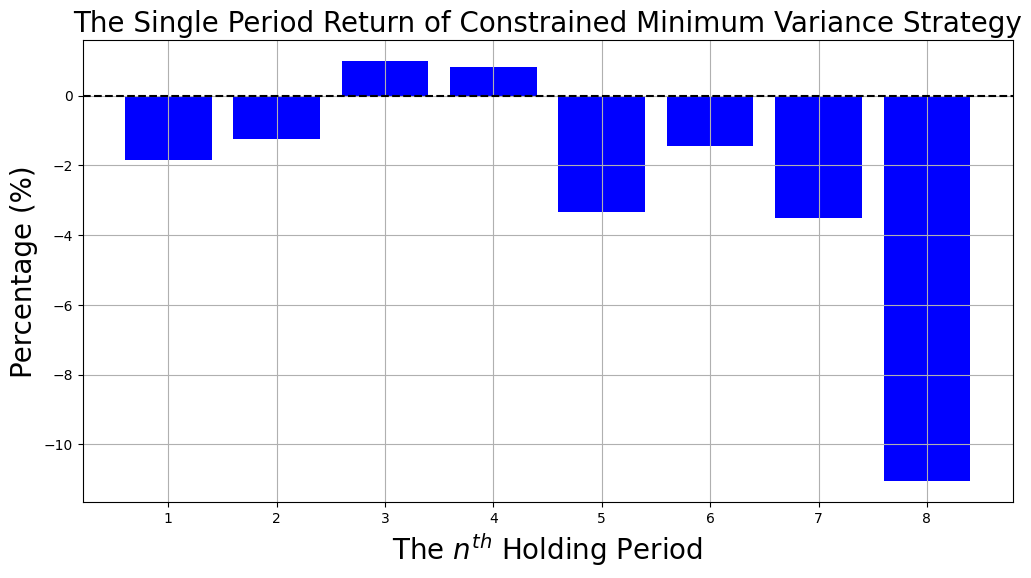

In [ ]:
# Create a plot for single period return after each holding period.
plt.figure(figsize=(12, 6))
plt.bar(range(1, len(Rolling_test)+1), (Holding_MinV.sum()-1) * 100, color='blue')
plt.axhline(0, c='k', ls='--')
plt.xlabel('The $n^{th}$ Holding Period', fontsize=20)
plt.ylabel('Percentage (%)', fontsize=20)
plt.title('The Single Period Return of Constrained Minimum Variance Strategy',
          fontsize=20)
plt.grid(True)
# plt.axis([2000, 2025, 0, 60])
# plt.legend(fontsize=20)
plt.show()

# Tangency Portfolio

In [67]:
## Calculate the optimal weight using rolling windows.
Weight_Tan = pd.DataFrame()
_col = []
for _period in Rolling_test:
    weight_t = Func_OptWeight( _period, method=2 )
    ## Scale up to make sure the sum of actual weights is 100%.
    weight_t = weight_t / weight_t.sum()
    Weight_Tan = pd.concat([ Weight_Tan, pd.DataFrame(weight_t) ], axis=1)
    _col.append( _period.index[-1] )

Weight_Tan = Weight_Tan.T
Weight_Tan.index = _col
Weight_Tan.columns = Stock_close.columns

Exposures_Tan, Holding_Tan, Weight_Tan_end = Func_Holding(Weight_Tan)

## The mean and dispersion of the poortfolio Sharpes and variances.
Turnover_Tan, Sharpe_Tan, Var_Tan, _ = Func_Performance(Weight_Tan, Weight_Tan_end, Exposures_Tan)

print('Turnover:', Turnover_Tan)
print('Sharpes (mean):', Sharpe_Tan.mean()[0] )
print('Sharpes (sd):', Sharpe_Tan.std()[0] )
print('Risks (mean):', Var_Tan.mean()[0] )
print('Risks (sd):', Var_Tan.std()[0] )
Cmr_Tan = Cmr_fake(Holding_Tan)

Turnover: 0.12604753308079739
Sharpes (mean): -5.540708654640531
Sharpes (sd): 8.833472111322049
Risks (mean): 0.00048505232867080046
Risks (sd): 0.0005908588794223362


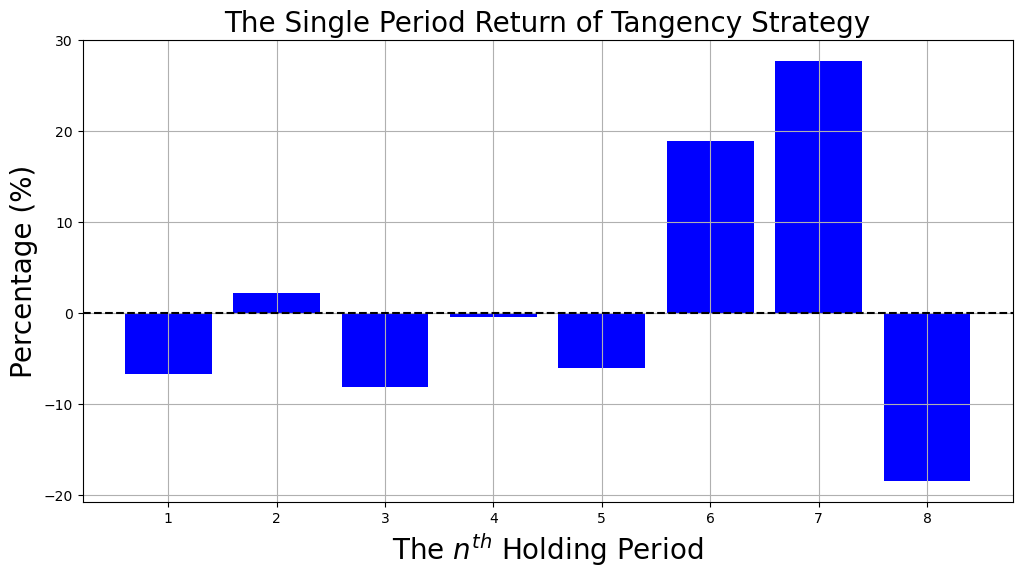

In [ ]:
# Create a plot for single period return after each holding period.
plt.figure(figsize=(12, 6))
plt.bar(range(1, len(Rolling_test)+1), (Holding_Tan.sum()-1) * 100, color='blue')
plt.axhline(0, c='k', ls='--')
plt.xlabel('The $n^{th}$ Holding Period', fontsize=20)
plt.ylabel('Percentage (%)', fontsize=20)
plt.title('The Single Period Return of Tangency Strategy',
          fontsize=20)
plt.grid(True)
# plt.axis([2000, 2025, 0, 60])
# plt.legend(fontsize=20)
plt.show()

# Highest Sharpe Strategy

In [68]:
## The number of stocks picked.
NumStock = int(N/10)

## Compute the Sharpe ratios of each stock over rolling windows.
Sharpe_roll = pd.DataFrame()
_col = []
for _period in Rolling_test:
    ## Get the critical dates.
    # Final date of the rolling window.
    finalRolling = _period.iloc[-1].name
    # First date of the rolling window.
    firstRolling = _period.iloc[0].name
    _col.append( finalRolling )

    Sharpe_t = (Stock_close.loc[ finalRolling ] - \
                    Stock_open.loc[ firstRolling ]) / \
                Stock_open.loc[ firstRolling ]
    var_t = Returns.loc[firstRolling : finalRolling].var()
    Sharpe_t = Sharpe_t / var_t

    Sharpe_roll = pd.concat([ Sharpe_roll, Sharpe_t ], axis=1)
Sharpe_roll.columns = _col


## Construct the weights of the Highest Sharpe Strategy that acts as a benchmark.
Weight_Sharpe = pd.DataFrame(0, index=Returns.columns, columns=range(len(Rolling_test)))
for _period in range(len(Rolling_test)):
    ## Find the index of the stocks with the highest Sharpe ratio among each holding periods.
    idx = Sharpe_roll.iloc[:, _period].nlargest(NumStock).index

    ## Naively invest stocks above for each holding period.
    Weight_Sharpe.loc[idx, _period] = 1 / NumStock


Weight_Sharpe.columns = _col
Weight_Sharpe = Weight_Sharpe.T


## Compute the changes in the holding within the holding period over time.
Exposures_Sharpe, Holding_Sharpe, Weight_Sharpe_end = Func_Holding(Weight_Sharpe)


## The mean and dispersion of the poortfolio Sharpes and variances.
Turnover_Sharpe, Sharpe_HighestSharpe, Var_HighestSharpe, _ = \
    Func_Performance(Weight_Sharpe, Weight_Sharpe_end, Exposures_Sharpe)

print('Turnover:', Turnover_Sharpe)
print('Sharpes (mean):', Sharpe_HighestSharpe.mean()[0] )
print('Sharpes (sd):', Sharpe_HighestSharpe.std()[0] )
print('Risks (mean):', Var_HighestSharpe.mean()[0] )
print('Risks (sd):', Var_HighestSharpe.std()[0] )
Cmr_sharpe = Cmr_fake(Holding_Sharpe)

Turnover: 0.0802790251571072
Sharpes (mean): -0.03703204521673564
Sharpes (sd): 7.696597674911339
Risks (mean): 0.0004081943732951045
Risks (sd): 0.0004949292493124204


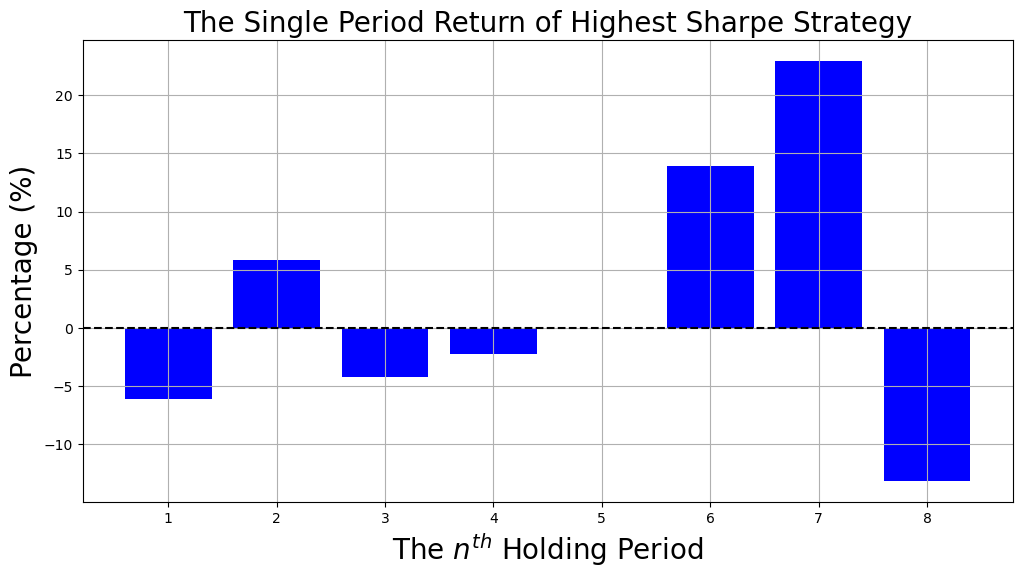

In [ ]:
# Create a plot for single period return after each holding period.
plt.figure(figsize=(12, 6))
plt.bar(range(1, len(Rolling_test)+1), (Holding_Sharpe.sum()-1) * 100, color='blue')
plt.axhline(0, c='k', ls='--')
plt.xlabel('The $n^{th}$ Holding Period', fontsize=20)
plt.ylabel('Percentage (%)', fontsize=20)
plt.title('The Single Period Return of Highest Sharpe Strategy',
          fontsize=20)
plt.grid(True)
# plt.axis([2000, 2025, 0, 60])
# plt.legend(fontsize=20)
plt.show()

# Clustering

In [7]:
import pandas as pd
import requests
import numpy as np
from bs4 import BeautifulSoup
import yfinance as yf
import itertools
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import sys
from sklearn.model_selection import train_test_split, LeaveOneOut, cross_val_score, KFold
from sklearn.cluster import KMeans
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import linkage,fcluster
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import to_tree
from sklearn.cluster import DBSCAN

In [8]:
# 計算dtw距離
def cal_dtw_distance(s_a, s_b):
    d=lambda x, y: abs(x - y)
    max_warping_window = 10000
    s_a, s_b = np.array(s_a), np.array(s_b)
    M, N = len(s_a), len(s_b)
    cost = sys.maxsize * np.ones((M, N))
    cost[0, 0] = d(s_a[0], s_b[0])
    for i in range(1, M):
        cost[i, 0] = cost[i - 1, 0] + d(s_a[i], s_b[0])
    for j in range(1, N):
        cost[0, j] = cost[0, j - 1] + d(s_a[0], s_b[j])
    for i in range(1, M):
        for j in range(max(1, i - max_warping_window),
                       min(N, i + max_warping_window)):
            choices = cost[i - 1, j - 1], cost[i, j - 1], cost[i - 1, j]
            cost[i, j] = min(choices) + d(s_a[i], s_b[j])
    return cost[-1, -1]
# 計算nodes深度
def get_leaf_depths(node):
    depths = {}
    def traverse(current_node, current_depth):
        if current_node:
            if current_node.is_leaf():
                depths[current_node.id] = current_depth
            else:
                traverse(current_node.left, current_depth + 1)
                traverse(current_node.right, current_depth + 1)
    traverse(node, 0)
    return depths
def stand(data):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    data = pd.DataFrame(scaled_data, columns=data.columns, index=data.index)
    return data

def dtw_matrix(data):
  X = data.index.values
  m = np.zeros((len(X),len(X)))
  for i in range(len(X)):
    for j in range(len(X)):
      m[i,j] = cal_dtw_distance(data.iloc[i,:],data.iloc[j,:])
  return pd.DataFrame(m,columns=data.index, index=data.index)


## Calculate the rolling windows for computing returns over test set.
# 2. Both rolling windows and holding periods and are in test set.
Rolling_close = []
for _i in range(0, len(Test_close)-(M_target+H_target), SpeedOfRolling):
    windows = Test_close.iloc[ _i : _i + M_target ]
    Rolling_close.append(windows)

# 3. Randomly pick n holding periods for comparison the strategies.
random.seed(random_state)
Rolling_close = [ Rolling_close[i] for i in random.sample(range(0, len(Rolling_close)), NumOfTestSample) ]

## Use dynamic time warpping to Clustering

In [ ]:
Y = Stock_close.iloc[-100:].corr()

X = stand(Stock_close.iloc[-100:].T)
X = dtw_matrix(X)

plt.figure(figsize=(8, 6))
plt.title('Correlation Matrix')
sns.heatmap(abs(Y), cmap='coolwarm', annot=False, square=True, cbar=True,vmin=0, vmax=1)
plt.show()

plt.figure(figsize=(8, 6))
plt.title('DTW Distance Matrix')
sns.heatmap((X)/X.max(), cmap='coolwarm', annot=False, square=True, cbar=True)
plt.show()

NameError: ignored

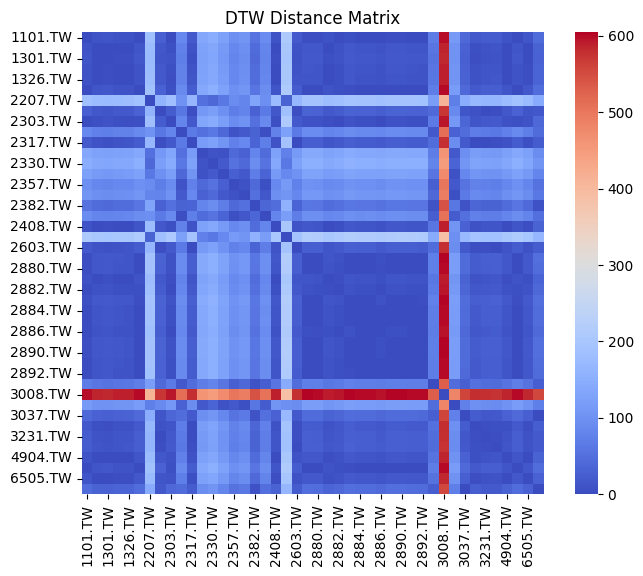

In [ ]:
plt.figure(figsize=(8, 6))
plt.title('DTW Distance Matrix')
sns.heatmap(X,cmap='coolwarm', annot=False, square=True, cbar=True)
plt.show()

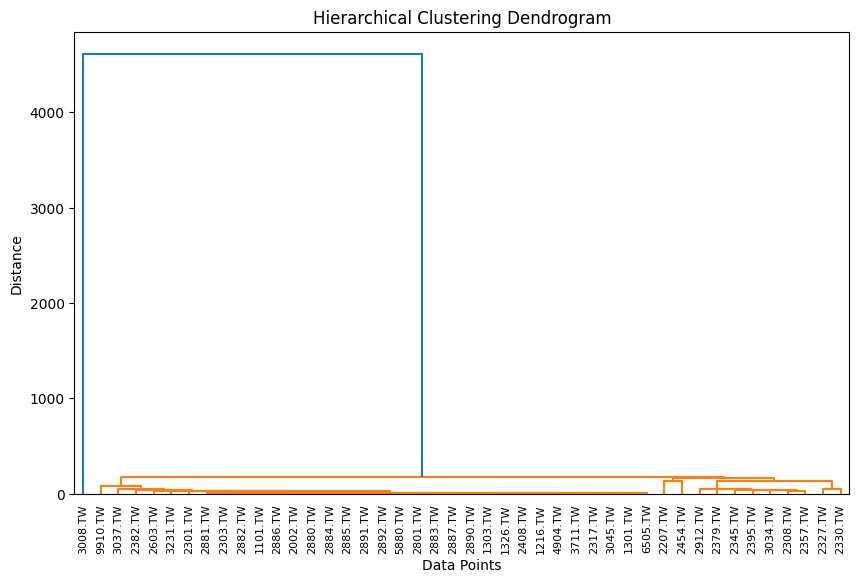

In [ ]:
# Hierarchical Clustering Demo
Z = linkage(stand(Stock_close.iloc[-1000:].T), metric = cal_dtw_distance)  # 'complete' linkage method
plt.figure(figsize=(10, 6))
tickers = Stock_close.columns
dendrogram(Z, labels=tickers, truncate_mode='lastp', p=len(tickers))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.show()

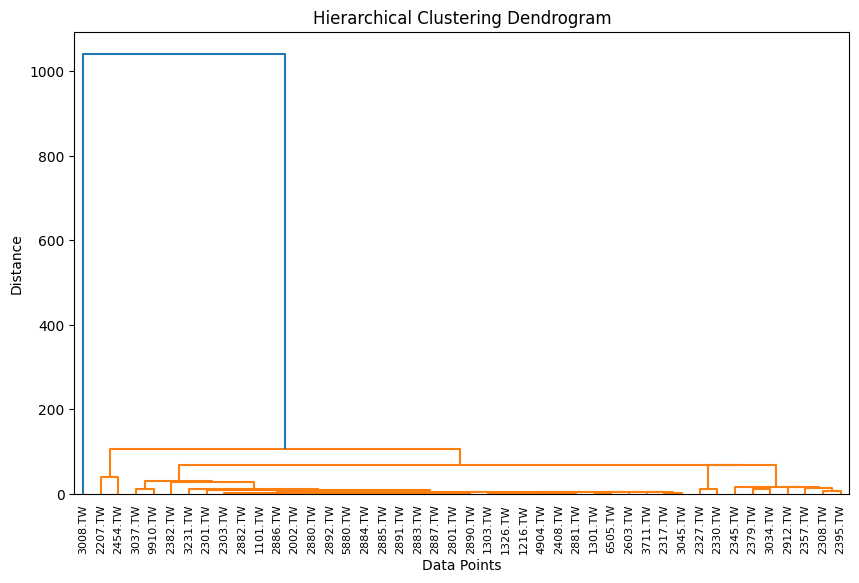

In [ ]:
# Hierarchical Clustering Demo
Z = linkage(stand(Stock_close.iloc[-250:].T), metric = cal_dtw_distance)  # 'complete' linkage method
plt.figure(figsize=(10, 6))
tickers = Stock_close.columns
dendrogram(Z, labels=tickers, truncate_mode='lastp', p=len(tickers))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.show()

# Hierarchical Clustering

In [73]:
# ma is a rolling window data for "Adj Close"
def Window_for_Hierarchical(ma):
  #抓股票的名稱以建立權重
  weights = pd.DataFrame(ma.T.index,columns = ['stock'])
  Adj_close = stand(ma.T)
  G = linkage(Adj_close)
  #將G轉為Tree
  tree = to_tree(G)
  leaf_depths = get_leaf_depths(tree)
  depths = pd.DataFrame(list(leaf_depths.items()), columns=['Leaf Node', 'Depth'])
  depths['weight'] = (1 / 2)**depths['Depth']
  weights[f'Period'] = pd.Series(depths['weight'].values, index=depths['Leaf Node']).reindex(weights.index)
  return weights.set_index('stock')


## Calculate the optimal weight using rolling windows.
Weight_Hierarch = pd.DataFrame()
_col = []
for _period in Rolling_close:
    weight_t = Window_for_Hierarchical( _period.drop(columns = '3008.TW') )
    ## Scale up to make sure the sum of actual weights is 100%.
    # Remove small numerical calculated weights.
    weight_t[ weight_t < 10 ** -4 ] = 0
    weight_t = weight_t / weight_t.sum()
    Weight_Hierarch = pd.concat([ Weight_Hierarch, weight_t ], axis=1)
    _col.append( _period.index[-1] )

Weight_Hierarch = Weight_Hierarch.T
Weight_Hierarch.index = _col
Weight_Hierarch.columns = Stock_close.drop(columns = '3008.TW').columns


Exposures_Hierarch, Holding_Hierarch, Weight_Hierarch_end = Func_Holding(Weight_Hierarch)
Cmr_Hierarch = Cmr_fake(Holding_Hierarch)
## The mean and dispersion of the poortfolio Sharpes and variances.
#Turnover_Hierarch, Sharpe_Hierarch, Var_Hierarch, _ = Func_Performance(Weight_Hierarch, Weight_Hierarch_end, Exposures_Hierarch)
print('Turnover:', Turnover_Hierarch)
print('Sharpes (mean):', Sharpe_Hierarch.mean()[0] )
print('Sharpes (sd):', Sharpe_Hierarch.std()[0] )
print('Risks (mean):', Var_Hierarch.mean()[0] )
print('Risks (sd):', Var_Hierarch.std()[0] )


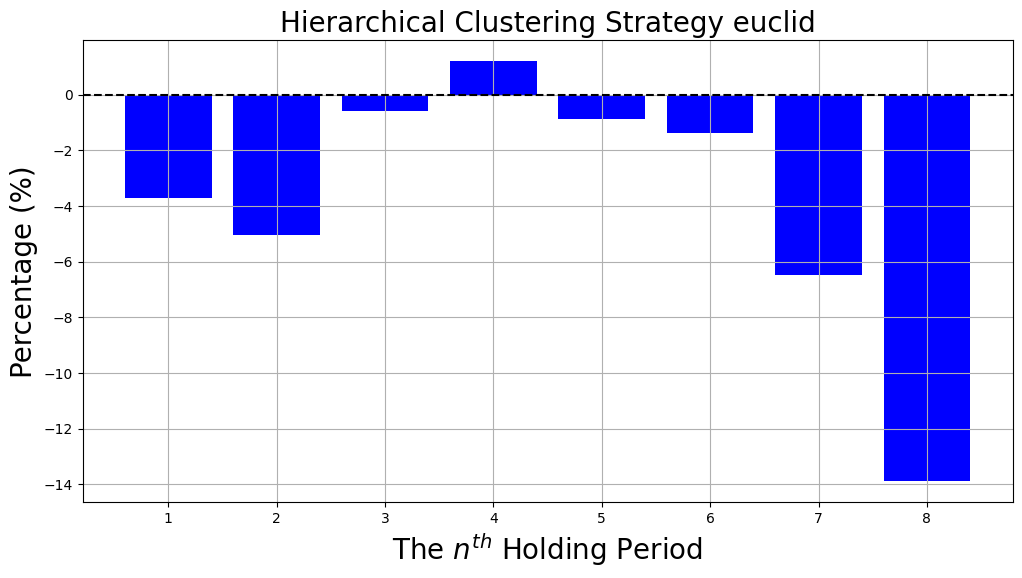

In [ ]:
# Create a plot for single period return after each holding period.
plt.figure(figsize=(12, 6))
plt.bar(range(1, len(Rolling_test)+1), (Holding_Hierarch.sum()-1) * 100, color='blue')
plt.axhline(0, c='k', ls='--')
plt.xlabel('The $n^{th}$ Holding Period', fontsize=20)
plt.ylabel('Percentage (%)', fontsize=20)
plt.title('Hierarchical Clustering Strategy euclid',
          fontsize=20)
plt.grid(True)
# plt.axis([2000, 2025, 0, 60])
# plt.legend(fontsize=20)
plt.show()

# DBSCAN

<ipython-input-79-08bf8db08a78>:24: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(cluster_points[:, 2], cluster_points[:, 3], c=color, s=50, label=f'Cluster {cluster_label}')


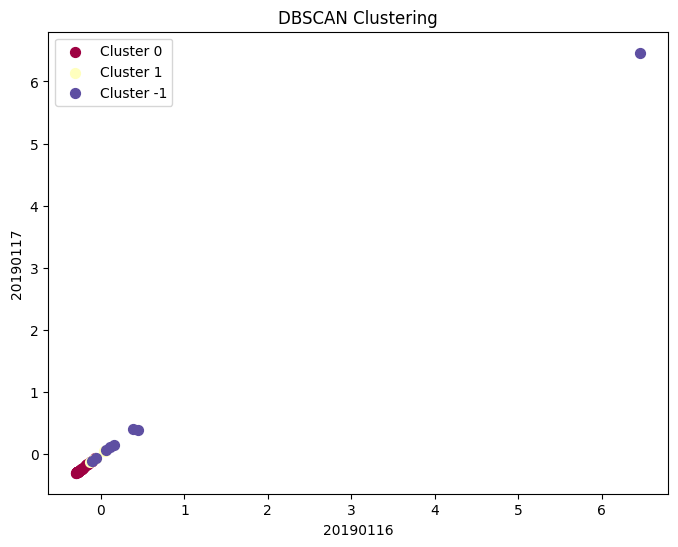

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import numpy as np

# 假设 Adj_close 是包含数据的 DataFrame
# 标准化数据
scaler = StandardScaler()
scaled_data = scaler.fit_transform(Rolling_close[0].T)

# 使用给定参数进行 DBSCAN 聚类
eps_value = 5
min_samples_value = 2
dbscan = DBSCAN(eps=eps_value)
clusters = dbscan.fit_predict(scaled_data)

# Create a colormap for the clusters
colors = plt.cm.Spectral(np.linspace(0, 1, len(set(clusters))))

# 绘制聚类结果（包括噪音点）
plt.figure(figsize=(8, 6))
for cluster_label, color in zip(set(clusters), colors):
    cluster_points = scaled_data[clusters == cluster_label]
    plt.scatter(cluster_points[:, 2], cluster_points[:, 3], c=color, s=50, label=f'Cluster {cluster_label}')

plt.title('DBSCAN Clustering')
plt.xlabel('20190116')
plt.ylabel('20190117')
plt.legend()
plt.show()



<ipython-input-82-2cca8d5b3cdb>:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(cluster_points[:, 2], cluster_points[:, 3], c=color, s=50, label=f'Cluster {cluster_label}')


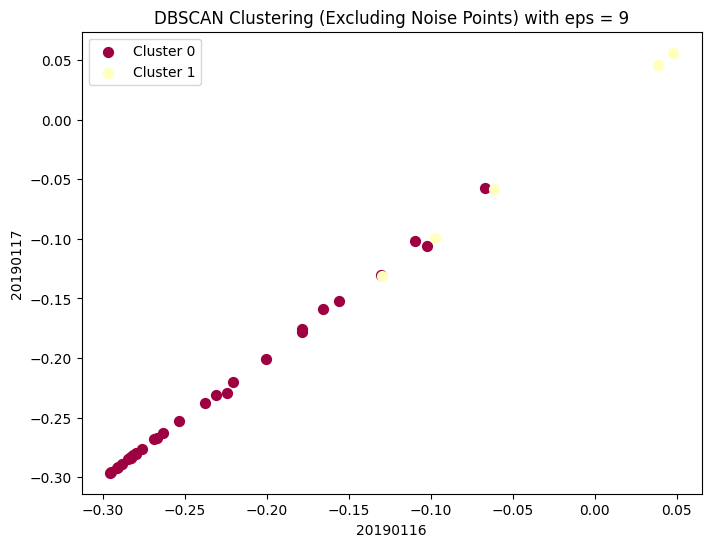

In [ ]:
# 绘制聚类结果（不包括噪音点）
plt.figure(figsize=(8, 6))
for cluster_label, color in zip(set(clusters), colors):
    if cluster_label == -1:
        continue  # 跳过噪音点
    cluster_points = scaled_data[clusters == cluster_label]
    plt.scatter(cluster_points[:, 2], cluster_points[:, 3], c=color, s=50, label=f'Cluster {cluster_label}')
plt.title('DBSCAN Clustering (Excluding Noise Points) with eps = 9')
plt.xlabel('20190116')
plt.ylabel('20190117')
plt.legend()
plt.show()



In [76]:
def Window_for_DBSCAN(ma):
  weights = pd.DataFrame(ma.T.index,columns = ['stock'])
  Adj_close = stand(ma.T)
  clustering = DBSCAN(eps = 5)
  labels = clustering.fit_predict(Adj_close)
  unique_labels, label_counts = np.unique(labels, return_counts=True)
  non_noise_labels = unique_labels[unique_labels != -1]
  num_clusters = len(non_noise_labels)
  weights = np.zeros(len(labels))
  for label in non_noise_labels:
      stocks_in_label = Adj_close.index[labels == label]
      num_stocks_in_label = len(stocks_in_label)
      weights[labels == label] = 1 / (num_clusters * num_stocks_in_label)
  weights_df = pd.DataFrame({'stock': Adj_close.index, 'weight': weights})
  weights_df['weight'] = weights_df['weight'] / weights_df['weight'].sum()
  return weights_df.set_index('stock')


## Calculate the optimal weight using rolling windows.
Weight_DBSCAN = pd.DataFrame()
_col = []
for _period in Rolling_close:
    weight_t = Window_for_DBSCAN( _period )
    ## Scale up to make sure the sum of actual weights is 100%.
    # Remove small numerical calculated weights.
    # weight_t[ weight_t < 10 ** -4 ] = 0
    # weight_t = weight_t / weight_t.sum()
    Weight_DBSCAN = pd.concat([ Weight_DBSCAN, weight_t ], axis=1)
    _col.append( _period.index[-1] )

Weight_DBSCAN = Weight_DBSCAN.T
Weight_DBSCAN.index = _col



Exposures_DBSCAN, Holding_DBSCAN, Weight_DBSCAN_end = Func_Holding(Weight_DBSCAN)

## The mean and dispersion of the poortfolio Sharpes and variances.
Turnover_DBSCAN, Sharpe_DBSCAN, Var_DBSCAN, _ = Func_Performance(Weight_DBSCAN, Weight_DBSCAN_end, Exposures_DBSCAN)

print('Turnover:', Turnover_DBSCAN)
print('Sharpes (mean):', Sharpe_DBSCAN.mean()[0] )
print('Sharpes (sd):', Sharpe_DBSCAN.std()[0] )
print('Risks (mean):', Var_DBSCAN.mean()[0] )
print('Risks (sd):', Var_DBSCAN.std()[0] )
Cmr_DBSCAN = Cmr_fake(Holding_DBSCAN)

Turnover: 0.051696383266931
Sharpes (mean): -8.758849239491317
Sharpes (sd): 2.926561554742934
Risks (mean): 8.712987816954187e-05
Risks (sd): 4.916877897186099e-05


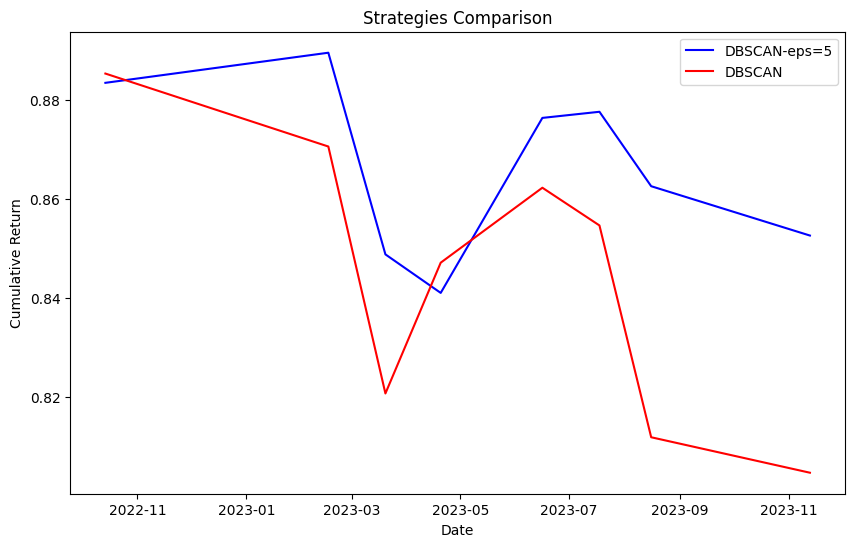

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(Cmr_DBSCAN.index, Cmr_DBSCAN.values, label='DBSCAN-eps=5', color='blue')
plt.plot(Cmr_DBSCAN1.index, Cmr_DBSCAN1.values, label='DBSCAN', color='red')


plt.legend()

plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Strategies Comparison')

plt.show()

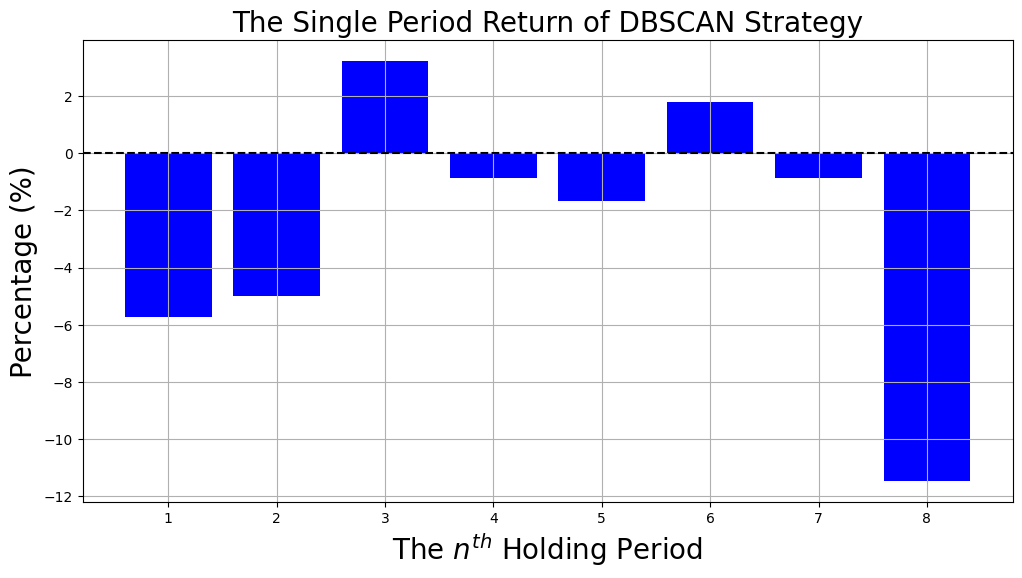

In [ ]:
# Create a plot for single period return after each holding period.
plt.figure(figsize=(12, 6))
plt.bar(range(1, len(Rolling_test)+1), (Holding_DBSCAN.sum()-1) * 100, color='blue')
plt.axhline(0, c='k', ls='--')
plt.xlabel('The $n^{th}$ Holding Period', fontsize=20)
plt.ylabel('Percentage (%)', fontsize=20)
plt.title('The Single Period Return of DBSCAN Strategy',
          fontsize=20)
plt.grid(True)
# plt.axis([2000, 2025, 0, 60])
# plt.legend(fontsize=20)
plt.show()

# Label

In [96]:
# data is train set we use
def optimal_k_model(data, response):
    k_values = range(1, 21)
    cv_scores = []
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, data, response, cv=10, scoring='accuracy')
        cv_scores.append(scores.mean())
    optimal_k = k_values[cv_scores.index(max(cv_scores))]
    knn = KNeighborsClassifier(n_neighbors=optimal_k)
    model = knn.fit(data, response)
    return model

def optimal_model(data):
  Adj_close = stand(data["Adj Close"].T)
  Volumne = stand(data["Volume"].T)
  High = stand(data["High"].T)
  Low = stand(data["Low"].T)
  Open = stand(data["Open"].T)
  y = ((data["High"].T.iloc[:,-730:].max(axis=1)-data["Adj Close"].T.iloc[:,-730])/data["Adj Close"].T.iloc[:,-730] >= 0.6).astype(int)
  model1 = optimal_k_model(Adj_close, y)
  model2 = optimal_k_model(Volumne, y)
  model3 = optimal_k_model(Low, y)
  model4 = optimal_k_model(Open, y)
  model5 = optimal_k_model(High, y)
  return model1,model2,model3,model4,model5
Train = Stock.iloc[ :-sizeOfTest ]
Test = Stock.iloc[ -sizeOfTest: ]
model1,model2,model3,model4,model5 = optimal_model(Train[-1050:])

In [90]:
# m is rolling period, and model1 to model5 is determined by optimal_k_model()
def window_for_knn(m):
  Adj_close = stand(m["Adj Close"].T)
  Volumne = stand(m["Volume"].T)
  High = stand(m["High"].T)
  Low = stand(m["Low"].T)
  Open = stand(m["Open"].T)
  weights = pd.DataFrame(Adj_close.index,columns = ['stock'])
  predictions = model1.predict(Adj_close) + model2.predict(High) + model3.predict(Low) + model4.predict(Volumne) + model5.predict(Open)
  p = (predictions >= 3).astype(int)
  weights[f'Period'] = p/p.sum()
  p_sum = p.sum()
  if p_sum == 0:
      weights[f'Period'] = np.zeros_like(p)
  else:
      weights[f'Period'] = p / p_sum
  return weights.set_index('stock')


In [91]:
Rolling_test_knn = []
for _i in range(0, len(Test)-(M_target+H_target), SpeedOfRolling):
    windows = Test.iloc[ _i : _i + M_target ]
    Rolling_test_knn.append(windows)

random.seed(random_state)
Rolling_test_knn = [ Rolling_test_knn[i] for i in random.sample(range(0, len(Rolling_test_knn)), NumOfTestSample) ]


In [ ]:
## Calculate the optimal weight using rolling windows.
Weight_knn = pd.DataFrame()
_col = []
for _period in Rolling_test_knn:
    weight_t = window_for_knn( _period )
    Weight_knn = pd.concat([ Weight_knn, weight_t ], axis=1)
    _col.append( _period.index[-1] )
Weight_knn = Weight_knn.T
Weight_knn.index = _col




Exposures_knn, Holding_knn, Weight_knn_end = Func_Holding(Weight_knn)

## The mean and dispersion of the poortfolio Sharpes and variances.
Turnover_knn, Sharpe_knn, Var_knn, _ = Func_Performance(Weight_knn, Weight_knn_end, Exposures_knn)

print('Turnover:', Turnover_knn)
print('Sharpes (mean):', Sharpe_knn.mean()[0] )
print('Sharpes (sd):', Sharpe_knn.std()[0] )
print('Risks (mean):', Var_knn.mean()[0] )
print('Risks (sd):', Var_knn.std()[0] )
Cmr_Knn = Cmr_fake(Holding_knn)

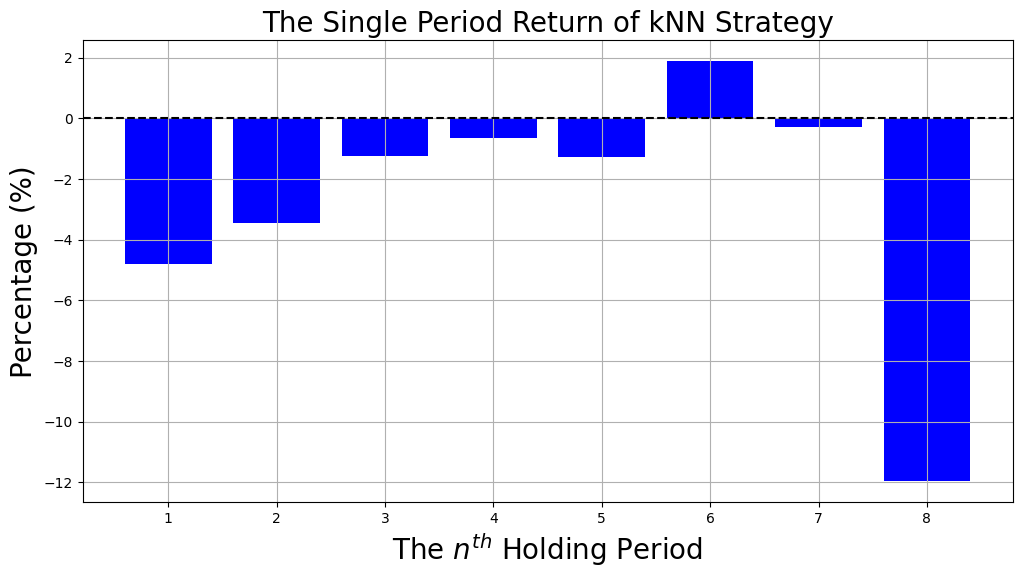

In [ ]:
# Create a plot for single period return after each holding period.
plt.figure(figsize=(12, 6))
plt.bar(range(1, len(Rolling_test)+1), (Holding_knn.sum()-1) * 100, color='blue')  # 將 "DBSCAN" 改為 "knn"
plt.axhline(0, c='k', ls='--')
plt.xlabel('The $n^{th}$ Holding Period', fontsize=20)
plt.ylabel('Percentage (%)', fontsize=20)
plt.title('The Single Period Return of kNN Strategy',  # 將 "DBSCAN" 改為 "knn"
          fontsize=20)
plt.grid(True)
# plt.axis([2000, 2025, 0, 60])
# plt.legend(fontsize=20)
plt.show()


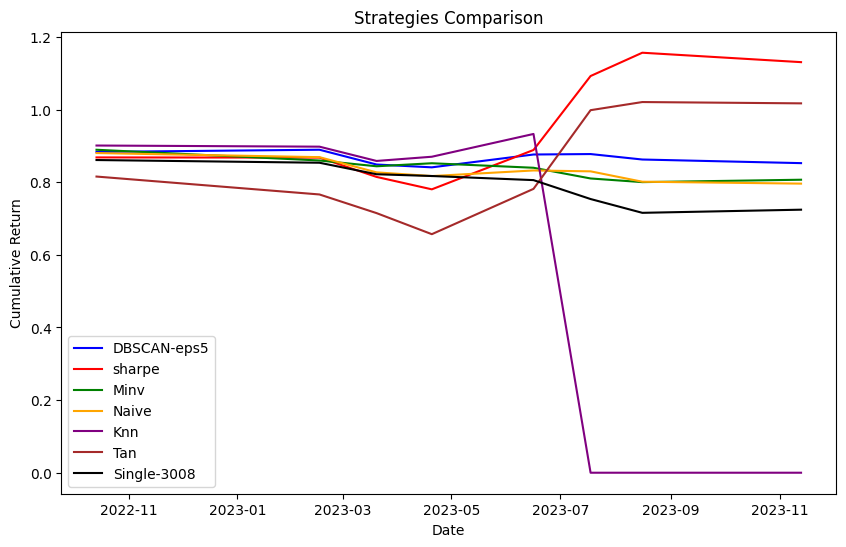

In [99]:
plt.figure(figsize=(10, 6))
plt.plot(Cmr_DBSCAN.index, Cmr_DBSCAN.values, label='DBSCAN-eps5', color='blue')
plt.plot(Cmr_sharpe.index, Cmr_sharpe.values, label='sharpe', color='red')
plt.plot(Cmr_Minv.index, Cmr_Minv.values, label='Minv', color='green')
plt.plot(Cmr_naive.index, Cmr_naive.values, label='Naive', color='orange')
plt.plot(Cmr_Knn.index, Cmr_Knn.values, label='Knn', color='purple')
plt.plot(Cmr_Tan.index, Cmr_Tan.values, label='Tan', color='brown')
plt.plot(Cmr_Hierarch.index, Cmr_Hierarch.values, label='Single-3008', color='black')

plt.legend()

plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Strategies Comparison')

plt.show()
